In [44]:
import torch

from torch import nn, optim

In [28]:
def view_tensor(tensor):
    return tensor.shape, tensor.stride()

In [38]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]

t_c = torch.tensor(t_c).unsqueeze(1) # add dimension at index 1
t_u = torch.tensor(t_u).unsqueeze(1) 

t_u.shape

torch.Size([11, 1])

In [39]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([ 4,  8,  9,  1,  7,  5,  0, 10,  6]), tensor([3, 2]))

In [40]:
t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

In [53]:
list(linear_model.parameters())

[Parameter containing:
 tensor([[0.1320]], requires_grad=True),
 Parameter containing:
 tensor([-0.8560], requires_grad=True)]

In [101]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val, t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train) # <1>
        loss_train = loss_fn(t_p_train, t_c_train)

        t_p_val = model(t_u_val) # <1>
        loss_val = loss_fn(t_p_val, t_c_val)
        
        optimizer.zero_grad()
        loss_train.backward() # <2>
        optimizer.step()

        if epoch == 1 or epoch % 1000 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                  f" Validation loss {loss_val.item():.4f}")


In [102]:
linear_model = nn.Linear(1, 1) # input_size, output_size, bias=True
optimizer = optim.SGD(
    linear_model.parameters(),
    lr=1e-2
)

In [103]:
training_loop(
    n_epochs = 5000, 
    optimizer = optimizer,
    model = linear_model,
    loss_fn = nn.MSELoss(), # <1>
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)


Epoch 1, Training loss 53.2353, Validation loss 274.0685
Epoch 1000, Training loss 4.0101, Validation loss 14.1338
Epoch 2000, Training loss 3.0235, Validation loss 6.7145
Epoch 3000, Training loss 2.9750, Validation loss 5.4625
Epoch 4000, Training loss 2.9726, Validation loss 5.2043
Epoch 5000, Training loss 2.9725, Validation loss 5.1480


In [117]:
def simple_sequential_model(hidden_neurons):
    return nn.Sequential(
        nn.Linear(1, hidden_neurons),
        nn.Tanh(),
        nn.Linear(hidden_neurons, 1)
    )

In [128]:
seq_model = simple_sequential_model(2)

optimizer = optim.SGD(seq_model.parameters(), lr=1e-2) # <1>

training_loop(
    n_epochs = 10000, 
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)
    
print('output', seq_model(t_un_val))
print('answer', t_c_val)

Epoch 1, Training loss 110.0282, Validation loss 485.5361
Epoch 1000, Training loss 5.6724, Validation loss 82.3823
Epoch 2000, Training loss 8.2683, Validation loss 58.7460
Epoch 3000, Training loss 4.4779, Validation loss 29.7531
Epoch 4000, Training loss 3.7390, Validation loss 27.7771
Epoch 5000, Training loss 3.8752, Validation loss 32.3313
Epoch 6000, Training loss 3.9446, Validation loss 32.1209
Epoch 7000, Training loss 3.6381, Validation loss 29.6950
Epoch 8000, Training loss 3.8777, Validation loss 26.0475
Epoch 9000, Training loss 5.0444, Validation loss 33.8079
Epoch 10000, Training loss 3.8458, Validation loss 31.1554
output tensor([[21.2562],
        [12.4264]], grad_fn=<AddmmBackward0>)
answer tensor([[28.],
        [15.]])


In [129]:
from matplotlib import pyplot as plt

t_range = torch.arange(20., 90.).unsqueeze(1)
t_range_preds = (
    seq_model(t_range * 0.1)
        .detach() # remove grad (otherwise can't .numpy())
        .numpy()
)

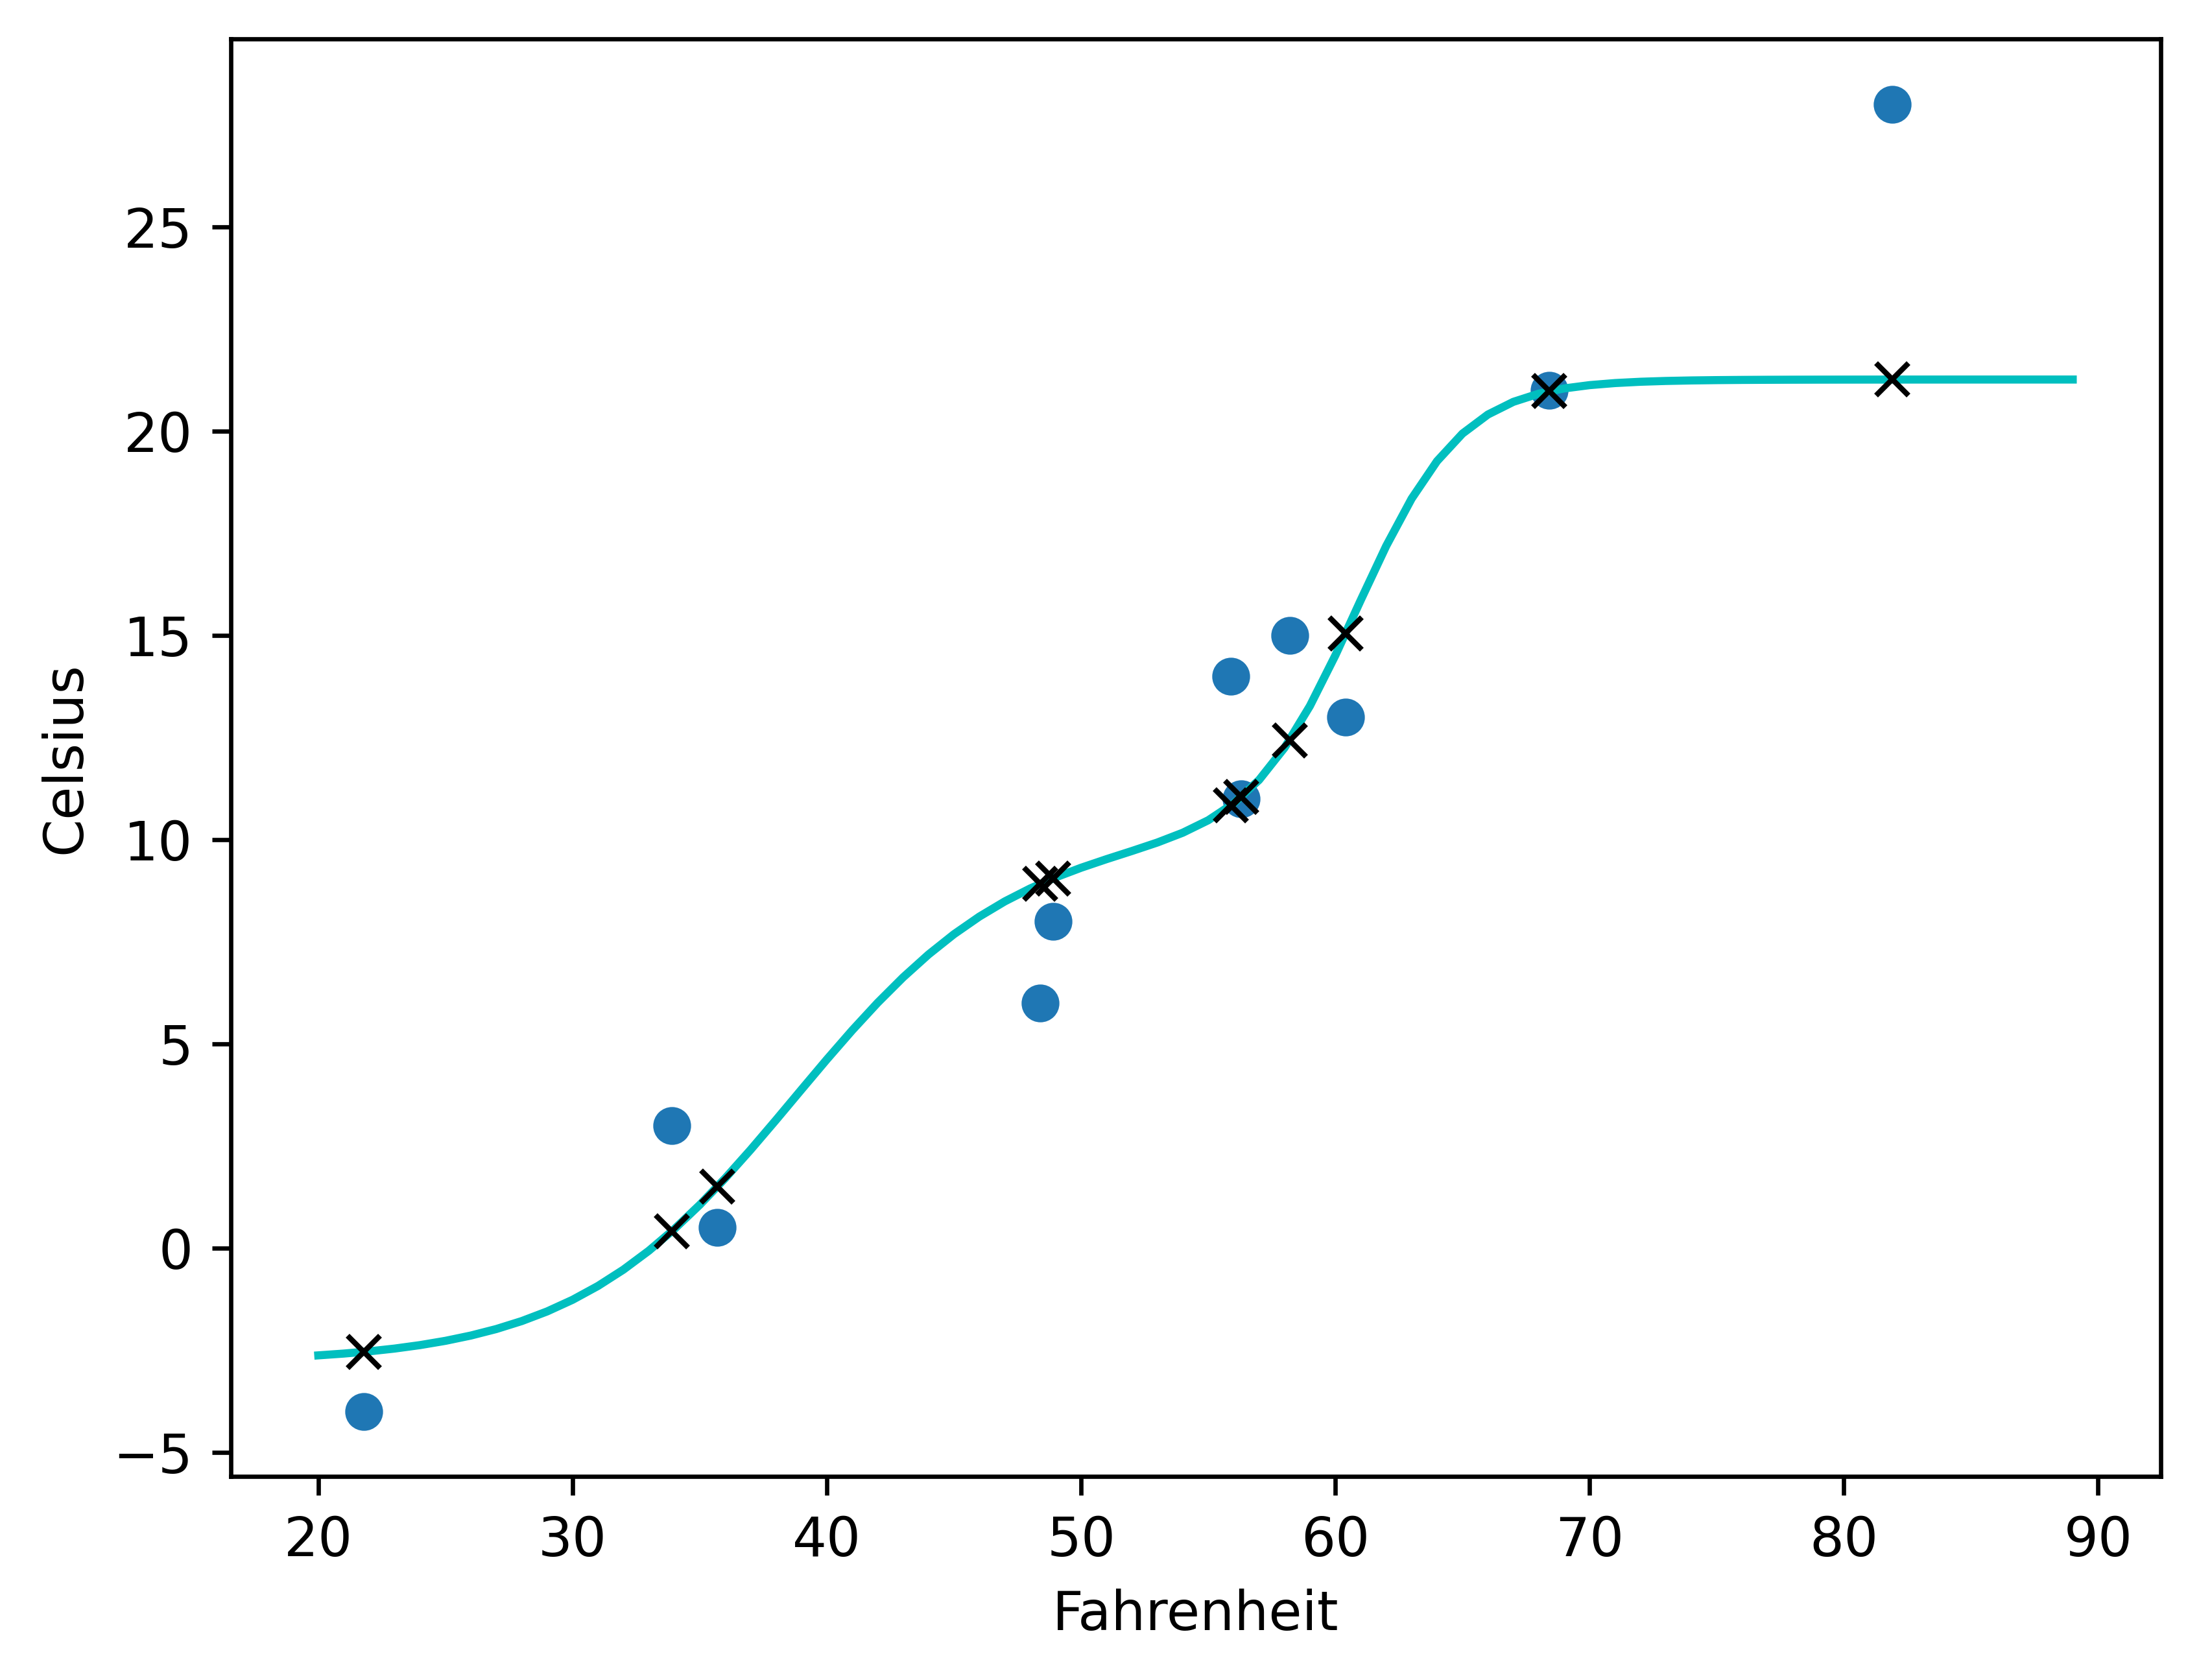

In [130]:
fig = plt.figure(dpi=600)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), t_range_preds, 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')